In [41]:
import jax
import jax.numpy as jnp
import h5py
from google.colab import drive
from typing import Optional, Callable
import matplotlib.pyplot as plt
print(jax.devices())

[gpu(id=0)]


# Data Preprocessing
keep in mind you have `train_catvnoncat.h5` and `test_catvnoncat.h5` in your `sample_data` directory.

In [5]:
def get_dataset():
  r = "sample_data"
  train_path = f"{r}/train_catvnoncat.h5"
  test_path = f"{r}/test_catvnoncat.h5"
  f_train, f_test = h5py.File(train_path, "r"), h5py.File(test_path, "r"),
  x_train_orig, y_train_orig = jnp.array(f_train['train_set_x']), jnp.array(f_train["train_set_y"]).reshape(1, -1)
  x_test_orig, y_test_orig = jnp.array(f_test['test_set_x']), jnp.array(f_test["test_set_y"]).reshape(1, -1)
  return x_train_orig, y_train_orig, x_test_orig, y_test_orig

(12288, 209)


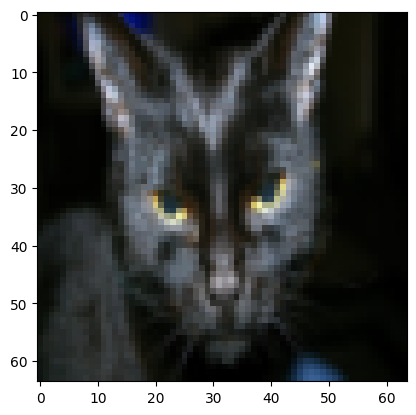

In [42]:
x_train_orig, y_train_orig, x_test_orig, y_test_orig = get_dataset()

x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1).T

x_train_norm = x_train_flatten / 255.
x_test_norm = x_test_flatten / 255.

print(x_train_norm.shape)
plt.imshow(x_train_orig[25])

# Jax Implementaion

This version uses Jax library and is faster than the other implementaions thanks to the JIT compilation.

In [7]:
def sigmoid(z):
  return 1 / (1 + jnp.exp(-z))

@jax.jit
def train_step(w1, b1, x, y):
  def logistic_loss(w1, b1, x, y):
    m = x.shape[1]
    a = sigmoid(jnp.dot(w1.T, x) + b1)
    e = a - y
    l = -(jnp.sum(jnp.dot(y, jnp.log(a).T) + jnp.dot((1 - y), jnp.log(1 - a).T)) / m)
    return l
  dw, db = jax.grad(logistic_loss, (0, 1))(w1, b1, x, y)
  return dw, db, logistic_loss(w1, b1, x, y)

def train_jax(epochs, lr, x, y):
  w1 = jnp.zeros((x.shape[0], 1))
  b1 = 0.

  for i in range(epochs):
    dw, db, loss = train_step(w1, b1, x, y)
    if i % 100 == 0:
      print(loss)
    w1 = w1 - (lr * dw)
    b1 = b1 - (lr * db)

  return w1, b1

In [44]:
w1_jax, b1_jax = train_jax(2000, 0.005, x_train_norm, y_train_orig) # GPU: 1.46 sec at best

0.6931472
0.58450824
0.46694893
0.3760068
0.3314633
0.30327308
0.2798796
0.26004216
0.24294068
0.22800425
0.21481954
0.20307821
0.1925443
0.18303336
0.1743986
0.16652142
0.15930453
0.15266734
0.14654225
0.14087209


# Manual Implementaiton

This version uses no framework.

In [45]:
def train_manual(epochs, lr, x, y):
  w1 = jnp.zeros((x.shape[0], 1))
  b1 = 0.

  for i in range(epochs):
    m = x.shape[1]
    a = sigmoid(jnp.dot(w1.T, x) + b1)
    e = a - y
    l = -(jnp.sum(jnp.dot(y, jnp.log(a).T) + jnp.dot((1 - y), jnp.log(1 - a).T)) / m)
    dw = jnp.dot(x, e.T) / x.shape[1]
    db = jnp.sum(e) / x.shape[1]

    if i % 100 == 0:
      print(l)

    w1 = w1 - (lr * dw)
    b1 = b1 - (lr * db)

  return w1, b1

In [46]:
w1, b1 = train_manual(2000, 0.005, x_train_norm, y_train_orig) # GPU: 7.6 sec at best

0.69314724
0.5845084
0.46694902
0.37600687
0.3314633
0.30327308
0.2798796
0.26004216
0.24294071
0.22800425
0.21481952
0.20307821
0.1925443
0.18303336
0.17439863
0.16652142
0.15930454
0.15266734
0.14654225
0.14087209


# Pytorch Implementaion

In [39]:
import torch
import torch.nn as nn
import numpy as np

class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        a1 = self.linear(x)
        return torch.sigmoid(a1)

def train_torch(epochs, lr, x, y):
    model = LogisticRegression(x.shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for i in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(loss.item())

In [14]:
x_t = torch.from_numpy(np.array(x_train_norm[:])).float()
y_t = torch.from_numpy(np.array(y_train_orig.T[:])).float()

In [40]:
train_torch(2000, 0.005, x_t.t(), y_t) # GPU: 2.54 sec

0.7193525433540344
0.5815258622169495
0.46418237686157227
0.37420523166656494
0.3310624361038208
0.3029521703720093
0.279619425535202
0.2598297894001007
0.24276676774024963
0.22786135971546173
0.21470172703266144
0.20298083126544952
0.1924634575843811
0.18296600878238678
0.1743420660495758
0.16647396981716156
0.15926435589790344
0.15263323485851288
0.1465131789445877
0.14084717631340027


# TensorFlow Implementaion

In [36]:
import tensorflow as tf

class LogisticRegression(tf.keras.Model):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = tf.keras.layers.Dense(1, activation='linear')

    def call(self, inputs):
        a1 = self.linear(inputs)
        return tf.sigmoid(a1)

def train_tf_step(x, y, model, criterion, optimizer, i):
    with tf.GradientTape() as tape:
              outputs = model(x)
              loss = criterion(y, outputs)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i % 100 == 0:
        print(loss.numpy())

def train_tf(epochs, lr, x, y):
    model = LogisticRegression(x.shape[1])
    criterion = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    for i in range(epochs):
        train_tf_step(x, y, model, criterion, optimizer, i)

In [37]:
train_tf(2000, 0.005, tf.convert_to_tensor(x_train_norm.T), tf.convert_to_tensor(y_train_orig.T)) # GPU: 22.4 sec !!

0.6556897
0.58804363
0.47046772
0.3791087
0.3338617
0.3052979
0.28162754
0.26157457
0.24429962
0.22921997
0.2159148
0.20407063
0.19344781
0.18385929
0.17515627
0.16721858
0.15994783
0.15326245
0.14709409
0.14138488


# Prediction

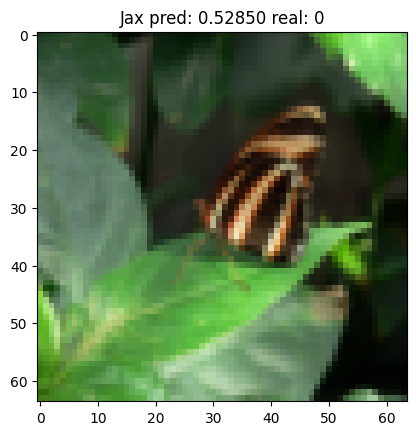

In [52]:
def pridict(w, b, i, msg):
  x, y = x_test_norm[:, i], y_test_orig[0, i]
  z = jnp.dot(w1.T, x) + b1
  a = sigmoid(z)
  plt.imshow(x_test_orig[i])
  plt.title(f"{msg} pred: {a[0]:.5f} real: {y}")
  plt.show()

# pridict(w1, b1, 5, "Manual")
pridict(w1_jax, b1_jax, 5, "Jax")